# Data Challenge

The challenge consists in processing a given dataset of transactions (*notas fiscais eletrônicas*) from a restaurant:

1. Parse and extract the data.
2. Identify a pattern on any set of fields that can help predict how much a customer will spend.
3. Calculate a sales forecast for the next week.

The input dataset has a `json` format. We will use the following python packages for that processing:

In [1]:
import json # to read the input dataset
import pandas as pd # data processing
from datetime import datetime # datetime processing
import calendar # datetime processing
import matplotlib.pyplot as plt # data plot
import seaborn as sns # data plot
import numpy as np # linear algebra
from sklearn import preprocessing # machine learning package

%matplotlib inline

Now we can read the dataset and output its first row as follows:

In [2]:
data = json.load(open('sample.txt'))
data[0]

{'complemento': {'valorTotal': 24.9},
 'dets': [{'nItem': '1',
   'prod': {'indTot': '1',
    'qCom': 1.0,
    'uCom': 'UN',
    'vProd': 3.5,
    'vUnCom': 3.5,
    'xProd': 'AGUA'}},
  {'nItem': '2',
   'prod': {'indTot': '1',
    'qCom': 0.312,
    'uCom': 'KG',
    'vProd': 21.4,
    'vUnCom': 68.6,
    'xProd': 'BUFFET'}}],
 'emit': {'cnpj': '01.234.567/0001-89',
  'enderEmit': {'fone': '1-650-933-4902',
   'uf': 'CA',
   'xBairro': '',
   'xLgr': '650 Castro St. unit 210',
   'xMun': 'Mountain View',
   'xPais': 'United States'},
  'xFant': 'TOTVS Labs'},
 'ide': {'dhEmi': {'$date': '2016-01-05T12:01:54.000Z'}, 'natOp': 'VENDA'},
 'infAdic': {'infCpl': 'Mesa 2'},
 'total': {'icmsTot': {'vDesc': 0.0,
   'vFrete': 0.0,
   'vOutro': 0.0,
   'vProd': 24.9,
   'vSeg': 0.0,
   'vTotTrib': 2.53,
   'vbc': 0.0,
   'vbcst': 0.0,
   'vcofins': 0.0,
   'vicms': 0.0,
   'vicmsDeson': 0.0,
   'vii': 0.0,
   'vipi': 0.0,
   'vnf': 24.9,
   'vpis': 0.0,
   'vst': 0.0}},
 'versaoDocumento': 1.0}

We can see that the dataset contains various nested field values; and only one nested dataset, named `dets`. Package `json` allows to parse such nested field values easily. For example, we can read the date that transaction #0 happened and convert it to `datetime` by using a single line of code:  

In [3]:
# converting str to dates
datetime.strptime(data[0]['ide']['dhEmi']['$date'], '%Y-%m-%dT%H:%M:%S.%fZ')

datetime.datetime(2016, 1, 5, 12, 1, 54)

The nested datasets `dets` store characteristics of the products purchased in each transaction. An interesting point is how many products we are dealing with:

In [4]:
# get products
prods = set()
for i in range(0, len(data)):
    for j in range(0, len(data[i]['dets'])):
        prods.add(data[i]['dets'][j]['prod']['xProd'].lower())


prods = list(prods) # to make easier future processing
prods

['sushi especial',
 'sake',
 'refrigerante',
 'bacardi',
 'cha',
 'bule cha',
 'whisky',
 'buffet',
 'caipiroska',
 'cerveja lata',
 'suco',
 'cerveja',
 'sobremesa',
 'harumaki',
 'limonada',
 'docinhos',
 'cafe expresso',
 'agua',
 'sashimi',
 'caipirinha',
 'uramaki',
 'temaki',
 'vinho',
 'yakissoba']

Wow! We have a relatively small number of products. And how many restaurants exist in that dataset?

In [5]:
# get all cnpjs
cnpjs = set()
for i in range(0, len(data)):
    cnpjs.add(data[i]['emit']['cnpj'])

cnpjs

{'01.234.567/0001-89'}

We only have one restaurant. Things are getting easier :) 

We also have a field for the type of transaction. Let's take a look at that field: 

In [6]:
# get all transaction natures
opNats = set()
for i in range(0, len(data)):
    opNats.add(data[i]['ide']['natOp'])

# just one natOp, VENDAs!
opNats

{'VENDA'}

We only have one type of transaction too.

Having in mind the above findings, we will transform the original dataset. Our objective is to store the most relevant information in such a way that a traditional data mining or machine learning algorithm can process.

That way, or format, is a tabular dataset. The format of the tabular dataset consists in a set of attributes (fields), where each field value can be numeric or nominal. In prediction tasks, we also have a special attribute named class. Depending on the type of the class attribute, we will be dealing with a regression problem (for numeric class values) or with a classification problem (for nominal class values).

Therefore, a natural approach is that our new tabular dataset has as many attributes as the number of products. The transformation will map one row of the original dataset to one row of the new tabular dataset. For a given transaction (row), the attribute values of our new tabular dataset will be `True` for the products purchased in that transaction, and `False` for the other products.

In our tabular dataset, we will also include two important numeric attributes: the date and bill of each transaction. "Bill" will be our target variable (class attribute): we are interested in calculating a sales forecast for the next week. 

In order to calculate such a forecast, we will also sort by the transaction date.

Let's create such a tabular dataset by using `pandas`:

In [7]:
# set up attributes
col = list(prods)
col.append('date')
col.append('bill')
# (1) Compute rows and (2) create pandas dataframe
# (1) Compute rows
tmp = [];
for i in range(0, len(data)):
    row = dict()

    # set product values
    for j in range(0, len(prods)):
        row[prods[j]] = False
    for j in range(0, len(data[i]['dets'])):
        row[data[i]['dets'][j]['prod']['xProd'].lower()] = True
    
    # set date-time and total value
    row['date'] = datetime.strptime(data[i]['ide']['dhEmi']['$date'], '%Y-%m-%dT%H:%M:%S.%fZ')
    row['bill'] = data[i]['complemento']['valorTotal']
    
    tmp.append(row)

# (2) Create pandas dataframe
df = pd.DataFrame(tmp, columns = col)
df.index = df.date
df.sort_index(axis=1, ascending=True, inplace = True)
df.dtypes

agua                        bool
bacardi                     bool
bill                     float64
buffet                      bool
bule cha                    bool
cafe expresso               bool
caipirinha                  bool
caipiroska                  bool
cerveja                     bool
cerveja lata                bool
cha                         bool
date              datetime64[ns]
docinhos                    bool
harumaki                    bool
limonada                    bool
refrigerante                bool
sake                        bool
sashimi                     bool
sobremesa                   bool
suco                        bool
sushi especial              bool
temaki                      bool
uramaki                     bool
vinho                       bool
whisky                      bool
yakissoba                   bool
dtype: object

Let's take a look at our target variable `bill`:

In [8]:
df.describe()

,bill
count,1635.000000
mean,55.504171
std,39.217462
min,9.740000
25%,30.985000
50%,43.260000
75%,69.230000
max,608.910000


The last table speaks for itself: all bill values are approximately around its mean (55.50), but we also have some outliers (see the min and max values). 

Let's also apply a simple discretization method to the class values:

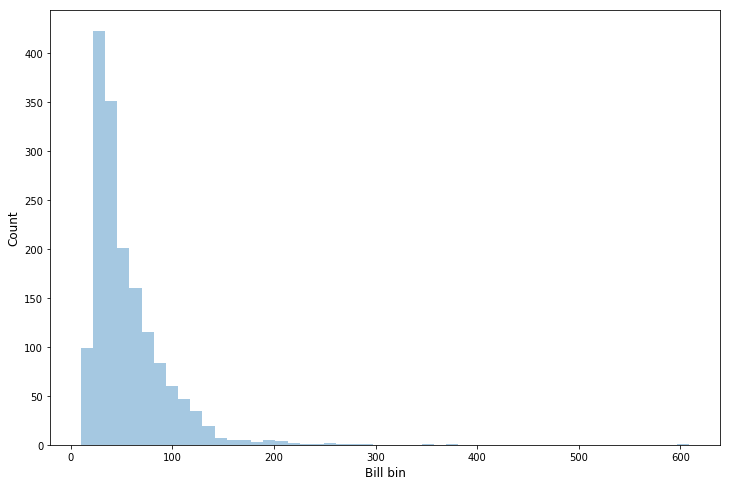

In [9]:
plt.figure(figsize=(12,8))
sns.distplot(df.bill.values, bins=50, kde=False)
plt.xlabel('Bill bin', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

Interesting... It looks like a nice Poisson Distribution.

And what about missing values (principally for transaction dates and bills)?

In [10]:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['Column Name', 'Missing Count']
missing_df = missing_df.loc[missing_df['Missing Count']>0]
missing_df = missing_df.sort_values(by='Missing Count')
missing_df

,Column Name,Missing Count


No missing values! We are lucky :)

In our tabular dataset we have a lot of boolean attributes. We should take a look at their True-False rates:

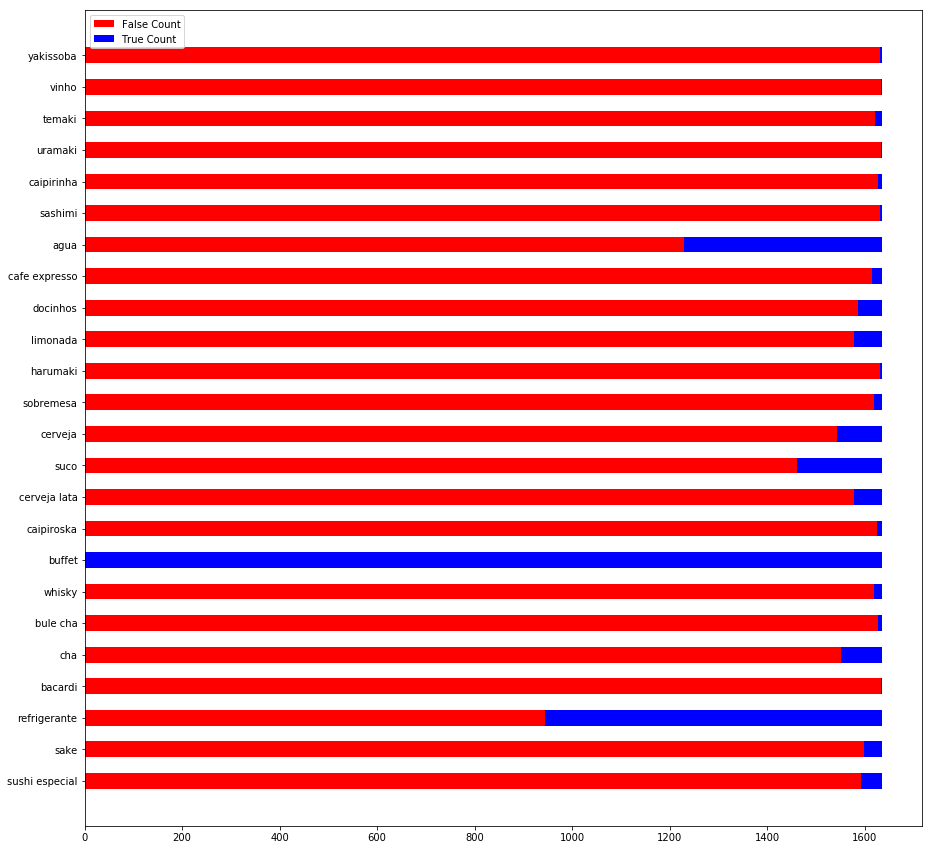

In [11]:
false_count_list = []
true_count_list = []
cols_list = prods
for col in cols_list:
    false_count_list.append((df[col] == False).sum())
    true_count_list.append((df[col] == True).sum())

N = len(cols_list)
ind = np.arange(N)
width = 0.5

plt.figure(figsize = (15,15))
p1 = plt.barh(ind, false_count_list, width, color='red')
p2 = plt.barh(ind, true_count_list, width, left=false_count_list, color="blue")
plt.yticks(ind, cols_list)
plt.legend((p1[0], p2[0]), ('False Count', 'True Count'))
plt.show()

The last figure shows that all transactions contain buffet as a product. Therefore, attribute `buffet` is useless for our prediction task. Many attributes are also highly unbalanced (for example, `vinho`), so we might need to apply some resampling method in order to generate more representative records (instances, examples) for our tabular dataset.

Here another interesting question: how do bills behave with respect to the day of week?

In [12]:
# getting total counts per day of week

# dow = day of week
df_dow = pd.DataFrame()
df_dow['Day of Week'] = df['date'].apply(lambda x: x.weekday()) # get the weekday index, between 0 and 6
df_dow['Day of Week'] = df_dow['Day of Week'].apply(lambda x: calendar.day_name[x])
df_dow['Bill'] = df['bill']

df_dow.groupby('Day of Week').sum()

,Bill
Day of Week,
Friday,9042.46
Monday,12076.14
Saturday,10858.63
Thursday,12872.85
Tuesday,19869.12
Wednesday,26030.12


According to the last table, it seems like that restaurant have some kind of promotion on Wednesdays, and maybe it is more expensive on Fridays :)

It also seems like the restaurant is closed on Sundays.

We can see a similar pattern in bill counts:

In [13]:
df_dow.groupby('Day of Week').count()

,Bill
Day of Week,
Friday,219
Monday,232
Saturday,177
Thursday,265
Tuesday,364
Wednesday,378


In order to calculate sales forecast for the next week, let's examine how many weeks with are dealing with: 

In [14]:
# getting total counts per day of week

import calendar

df_week = pd.DataFrame()
df_week['Week'] = df['date'].apply(lambda x: x.isocalendar()[1]) # get the weekday index, between 0 and 6
df_week['Bill'] = df['bill']

df_week.groupby('Week').sum()

,Bill
Week,
1,24018.88
2,32139.80
3,34590.64


The dataset only contains transactions for a period of three weeks. Unfortunatelly, that information is insufficient to build a prediction model. We will need more records even to compute relatively accurate sales forecast for the next day.

With a sufficient amount of data, a candidate prediction algorithm is XGBoost, which dominates many Kaggle competitions.

An interesting prediction task is to know if the income will increase for the next day (week, 
or a given period of time in general). In this case, the target variable can be dichotomic and, different from sales forecast, we will be facing a classification problem.

Looking forward to seeing more data to do so :)